In [1]:
%matplotlib inline

import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, Subset, DataLoader
from torchvision import transforms as _transforms, tv_tensors
import torchvision.transforms.v2 as T
import json
from matplotlib import patches
import matplotlib.pyplot as plt
from collections import defaultdict
from PIL import Image, ImageDraw
import numpy as np
from pathlib import Path
import gc
import random
import os
from torch_lr_finder import LRFinder, TrainDataLoaderIter
from datetime import datetime
import time
import timm

c:\Users\zack\anaconda3\envs\bohb_pt\lib\site-packages\torch_lr_finder\lr_finder.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


#### <center> Load Images and Annotations </center>

In [2]:
# load annotations from json file
annos = json.load(open("S:/Zack/Deep Learning/Chestnut_Bur_Instance_Segmentation/route9_orchard3/data/_annotations.coco.json"))

# convert the annos dict to a df
annos_df = pd.DataFrame(annos["annotations"])
df = pd.DataFrame()
df["tree_id"] = annos_df["image_id"].apply(lambda x: annos["images"][x]["file_name"].split("_")[0])
df["file_name"] = annos_df["image_id"].apply(lambda x: annos["images"][x]["file_name"])
df["file_name"] = df["file_name"].apply(lambda x: x.split("_")[0] + ".png")
categories = [cat["name"] for cat in annos["categories"]]
df["category_name"] = annos_df["category_id"].apply(lambda x: categories[x])
df["bbox"] = annos_df["bbox"].apply(lambda x: torch.tensor(x))
df["area"] = annos_df["area"].apply(lambda x: torch.tensor(x))
df["segmentation"] = annos_df["segmentation"].apply(lambda x: torch.tensor(x))
df["iscrowd"] = annos_df["iscrowd"]

reviewed_trees = [392, 60, 44, 91, 272, 51, 152, 329, 286, 320, 280, 366, 304] # subset for testing 

df = df[df["tree_id"].isin([str(tree_id) for tree_id in reviewed_trees])]

image_names = df["file_name"].unique()

#### <center> Image Pre-processing </center>

In [3]:
# def create_polygon_mask(mask, polys, color):
#     for poly in polys:
#         poly_mask = Image.new("L", (mask.shape[1], mask.shape[0]), 0)
#         ImageDraw.Draw(poly_mask).polygon(poly, fill=color)
#         poly_mask = np.array(poly_mask)
#         mask = np.maximum(mask, poly_mask)
#     return mask

# def transform_bbox_to_tile_coords(bbox, tile_left, tile_top, global_left, global_top, tile_width, tile_height):
#     x, y, w, h = bbox
#     x_padded = x - global_left
#     y_padded = y - global_top
#     x_in_tile = x_padded - tile_left
#     y_in_tile = y_padded - tile_top
#     x2_in_tile = x_in_tile + w
#     y2_in_tile = y_in_tile + h
#     x_clamped = max(0, min(tile_width, x_in_tile))
#     y_clamped = max(0, min(tile_height, y_in_tile))
#     x2_clamped = max(0, min(tile_width, x2_in_tile))
#     y2_clamped = max(0, min(tile_height, y2_in_tile))
#     clipped_w = x2_clamped - x_clamped
#     clipped_h = y2_clamped - y_clamped
#     if clipped_w <= 0 or clipped_h <= 0:
#         return None
#     return (x_clamped, y_clamped, clipped_w, clipped_h)

# # Define output directories
# base_output_dir = Path('S:/Zack/Deep Learning/Chestnut_Bur_Instance_Segmentation/U-Net/data')
# preprocessed_image_dir = base_output_dir / 'images'
# mask_output_dir = base_output_dir / 'masks'

# preprocessed_image_dir.mkdir(parents=True, exist_ok=True)
# mask_output_dir.mkdir(parents=True, exist_ok=True)

# image_dir = 'S:/Zack/Deep Learning/Chestnut_Bur_Instance_Segmentation/route9_orchard3/data/images'
# preprocessed_data = []

# # Overlap settings
# tile_height, tile_width = 224, 224
# overlap_pct = 0.20  # 20% overlap
# stride_y = int(tile_height * (1 - overlap_pct))
# stride_x = int(tile_width * (1 - overlap_pct))

# for file_name in df["file_name"].unique():
#     try:
#         print(f"Processing file: {file_name}")
#         row = df[df["file_name"] == file_name]
#         image_path = Path(image_dir) / row["file_name"].values[0]
#         image = Image.open(image_path).convert('RGB')
#         image_np = np.array(image)

#         # Process canopy polygon
#         canopy_poly = row[row["category_name"] == "Canopy"]["segmentation"].values
#         canopy_poly = [np.array(poly[0]).reshape(-1, 2).tolist() for poly in canopy_poly]
#         canopy_poly = [[tuple(p) for p in poly] for poly in canopy_poly]
#         canopy_mask = np.zeros((image_np.shape[0], image_np.shape[1]), dtype=np.uint8)
#         canopy_mask = create_polygon_mask(canopy_mask, canopy_poly, 1)

#         # Process Chestnut-burr polygons
#         bur_poly = row[row["category_name"] == "Chestnut-burr"]["segmentation"].values
#         bur_poly = [np.array(poly[0]).reshape(-1, 2).tolist() for poly in bur_poly]
#         bur_poly = [[tuple(p) for p in poly] for poly in bur_poly]
#         bur_masks = []
#         for poly in bur_poly:
#             mask = np.zeros((image_np.shape[0], image_np.shape[1]), dtype=np.uint8)
#             mask = create_polygon_mask(mask, [poly], 1)
#             bur_masks.append(mask)
#         mask_image = np.stack(bur_masks, axis=0)
#         mask_image = mask_image.transpose(1, 2, 0)

#         # Crop the image using canopy bounding box with padding
#         canopy_bbox = row[row["category_name"] == "Canopy"]["bbox"].values[0]
#         padding = 50.0
#         padded_bbox = [
#             max(0, int(canopy_bbox[0] - padding)),
#             max(0, int(canopy_bbox[1] - padding)),
#             min(image_np.shape[1], int(canopy_bbox[0] + canopy_bbox[2] + padding)),
#             min(image_np.shape[0], int(canopy_bbox[1] + canopy_bbox[3] + padding))
#         ]
#         image_cropped = image_np[padded_bbox[1]:padded_bbox[3], padded_bbox[0]:padded_bbox[2]]
#         mask_cropped = mask_image[padded_bbox[1]:padded_bbox[3], padded_bbox[0]:padded_bbox[2], :]

#         # Fill background with black outside of canopy mask
#         canopy_mask_cropped = canopy_mask[padded_bbox[1]:padded_bbox[3], padded_bbox[0]:padded_bbox[2]].astype(bool)
#         fill_color = [0, 0, 0]
#         for c in range(3):
#             image_cropped[..., c][~canopy_mask_cropped] = fill_color[c]

#         transform = T.Compose([
#             T.ToImage(),
#             T.ToDtype(torch.float32, scale=True),
#             T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
#         ])
#         image_cropped = transform(image_cropped).permute(1, 2, 0).numpy()  # Normalize and convert back to [H, W, C]

#         image_height, image_width, _ = image_cropped.shape
#         padded_height = ((image_height + tile_height - 1) // tile_height) * tile_height
#         padded_width = ((image_width + tile_width - 1) // tile_width) * tile_width

#         padded_image = np.zeros((padded_height, padded_width, 3), dtype=np.float32)
#         padded_image[:image_height, :image_width, :] = image_cropped

#         padded_mask = np.zeros((padded_height, padded_width, mask_cropped.shape[2]), dtype=np.uint8)
#         padded_mask[:image_height, :image_width, :] = mask_cropped

#         for tile_y in range(0, padded_height - tile_height + 1, stride_y):
#             for tile_x in range(0, padded_width - tile_width + 1, stride_x):
#                 tile_image = padded_image[tile_y:tile_y+tile_height, tile_x:tile_x+tile_width, :]
#                 tile_mask = padded_mask[tile_y:tile_y+tile_height, tile_x:tile_x+tile_width, :]
#                 # Only remove tiles that are entirely padding (i.e., tile_image is all zeros)
#                 if np.all(tile_image == 0):
#                     continue

#                 tile_bboxes = []
#                 tile_masks = []

#                 bur_rows = row[row["category_name"] == "Chestnut-burr"]
#                 for bbox_arr, mask_arr in zip(bur_rows["bbox"].values, bur_rows["segmentation"].values):
#                     tile_bbox = transform_bbox_to_tile_coords(
#                         bbox_arr,
#                         tile_x, tile_y,
#                         padded_bbox[0], padded_bbox[1],
#                         tile_width, tile_height
#                     )
#                     if tile_bbox is None:
#                         continue
#                     bx, by, bw, bh = tile_bbox
#                     tile_bboxes.append({
#                         "tree_id": bur_rows["tree_id"].values[0],
#                         "file_name": f"{Path(file_name).stem}_{tile_y}_{tile_x}",
#                         "bbox_x": float(bx),
#                         "bbox_y": float(by),
#                         "bbox_w": float(bw),
#                         "bbox_h": float(bh),
#                         "category_name": "Chestnut-burr",
#                         "iscrowd": int(bur_rows["iscrowd"].values[0]),
#                         "tile_x": tile_x,
#                         "tile_y": tile_y
#                     })

#                     # Create mask for the bounding box
#                     mask = np.zeros((tile_height, tile_width), dtype=np.uint8)
#                     poly = np.array(mask_arr[0]).reshape(-1, 2).tolist()
#                     poly = [(p[0] - padded_bbox[0] - tile_x, p[1] - padded_bbox[1] - tile_y) for p in poly]
#                     mask = create_polygon_mask(mask, [poly], 1)
#                     tile_masks.append(mask)

#                 if not tile_bboxes:
#                     continue

#                 # Stack the masks to create the mask image
#                 tile_mask = np.stack(tile_masks, axis=2)

#                 tile_image_path = preprocessed_image_dir / f"{Path(file_name).stem}_{tile_y}_{tile_x}.npy"
#                 tile_mask_path = mask_output_dir / f"{Path(file_name).stem}_{tile_y}_{tile_x}.npz"
#                 np.save(tile_image_path, tile_image)
#                 np.savez_compressed(tile_mask_path, tile_mask)

#                 preprocessed_data.extend(tile_bboxes)

#     except Exception as e:
#         print(f"Error processing file {file_name}: {e}")

# preprocessed_df = pd.DataFrame(preprocessed_data)
# updated_csv_path = base_output_dir / 'annotations.csv'
# preprocessed_df.to_csv(updated_csv_path, index=False)

# gc.collect()
# torch.cuda.empty_cache()

#### <center> PyTorch Dataset </center>

In [4]:
class ChestnutBurSegmentation(Dataset):
    def __init__(self, images_dir, masks_dir, annotations_csv, transform=None):
        self.images_dir = Path(images_dir)
        self.masks_dir = Path(masks_dir)
        self.annotations = pd.read_csv(annotations_csv)
        self.transform = transform
        self.file_names = self.annotations["file_name"].unique()

    def __len__(self):
        return len(self.file_names)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        file_name = self.file_names[idx]
        image_path = self.images_dir / f'{Path(file_name).stem}.npy'
        mask_path = self.masks_dir / f'{Path(file_name).stem}.npz'

        # Load the preprocessed image and mask
        image = np.load(image_path)
        mask = np.load(mask_path)['arr_0']

        # Convert image and mask to tv_tensors
        image = tv_tensors.Image(torch.tensor(image).permute(2, 0, 1))  # [C, H, W]
        instance_masks = tv_tensors.Mask(torch.tensor(mask).permute(2, 0, 1))  # [N, H, W] where N is instances
        
        # Combine instance masks into binary mask
        binary_mask = torch.max(instance_masks, dim=0)[0].unsqueeze(0)  # [1, H, W]
        binary_mask = tv_tensors.Mask(binary_mask)

        # Get the annotations for the current file
        annotations = self.annotations[self.annotations["file_name"] == file_name]

        labels = [1] * len(annotations)  # All labels are "Chestnut-burr"
        bboxes = annotations[["bbox_x", "bbox_y", "bbox_w", "bbox_h"]].values
        bboxes = [torch.tensor([float(bbox[0]), float(bbox[1]), 
                              float(bbox[0] + bbox[2]), float(bbox[1] + bbox[3])], 
                              dtype=torch.float32) for bbox in bboxes]
        bboxes = torch.stack(bboxes, dim=0)
        iscrowd = annotations["iscrowd"].values
        area = (bboxes[:, 2] - bboxes[:, 0]) * (bboxes[:, 3] - bboxes[:, 1])

        # Create the target dictionary
        target = {
            "boxes": tv_tensors.BoundingBoxes(bboxes, 
                                            format=tv_tensors.BoundingBoxFormat.XYXY, 
                                            canvas_size=(image.shape[1], image.shape[2])),
            "labels": torch.tensor(labels, dtype=torch.int64),
            "image_id": idx,
            "area": area.clone().detach(),
            "iscrowd": torch.tensor(iscrowd, dtype=torch.uint8),
            "masks": binary_mask,  # Use binary mask for SmallObjectUNet
        }

        if self.transform:
            image, target = self.transform(image, target)

        return image, target

    @staticmethod
    def collate_fn(batch):
        return tuple(zip(*batch))

#### <center> Transformation Pipeline </center>

In [5]:
def get_transform(train):
    transforms = []
    if train:
        transforms.extend([
            T.RandomHorizontalFlip(0.5),
            T.RandomVerticalFlip(0.5),
            T.RandomRotation(degrees=(-45, 45)),
            
            # Add scale augmentation for small objects
            T.RandomAffine(
                degrees=0, 
                scale=(0.8, 1.2),
                translate=(0.1, 0.1)
            ),
            # Add noise resilience
            T.RandomApply([
                T.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0))
            ], p=0.3),
        ])
    transforms.append(T.ClampBoundingBoxes())
    return T.Compose(transforms)

#### <center> Plot Sample Batch </center>

In [6]:
images_dir = 'S:/Zack/Deep Learning/Chestnut_Bur_Instance_Segmentation/U-Net/data/images'
masks_dir = 'S:/Zack/Deep Learning/Chestnut_Bur_Instance_Segmentation/U-Net/data/masks'
annotations_csv = 'S:/Zack/Deep Learning/Chestnut_Bur_Instance_Segmentation/U-Net/data/annotations.csv'

sample_ds = ChestnutBurSegmentation(images_dir, 
                                    masks_dir, 
                                    annotations_csv,
                                    transform = get_transform(train=True))

sample_dl = DataLoader(sample_ds, 
                       batch_size = 4, 
                       shuffle = True, 
                       collate_fn = ChestnutBurSegmentation.collate_fn)

images, targets = next(iter(sample_dl))
images = [img for img in images]
targets = [{k: v for k, v in target.items()} for target in targets]

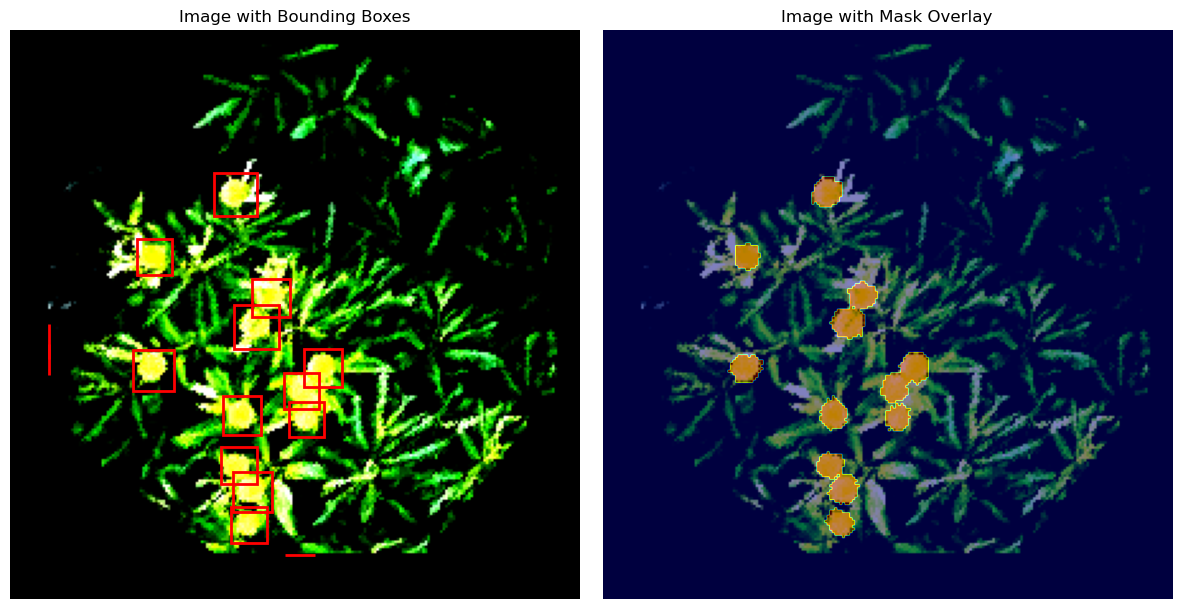

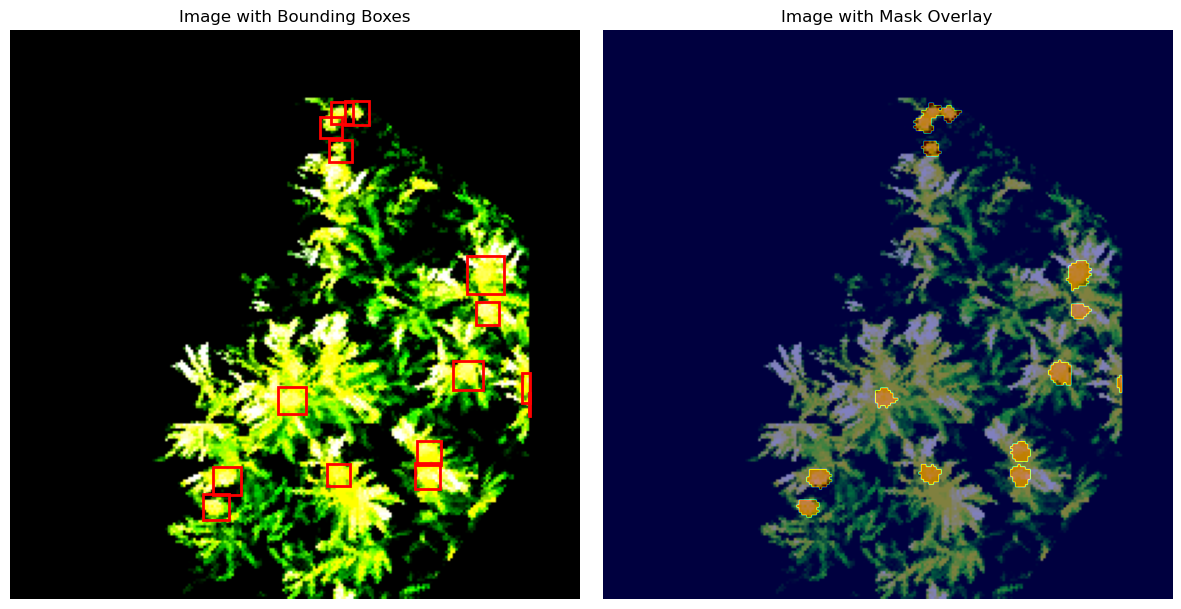

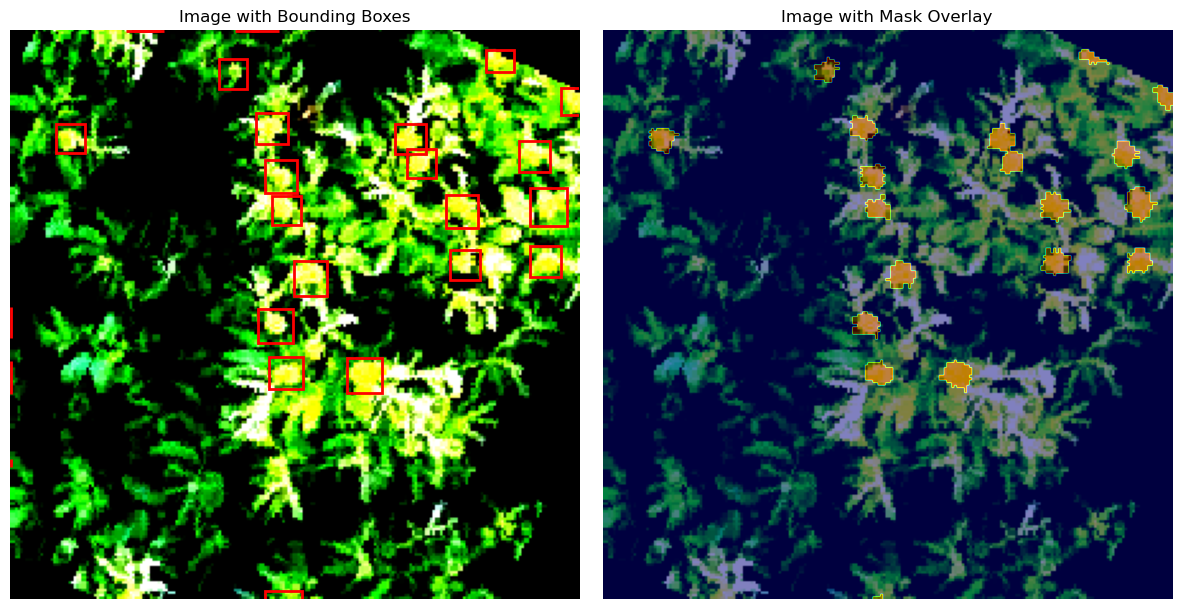

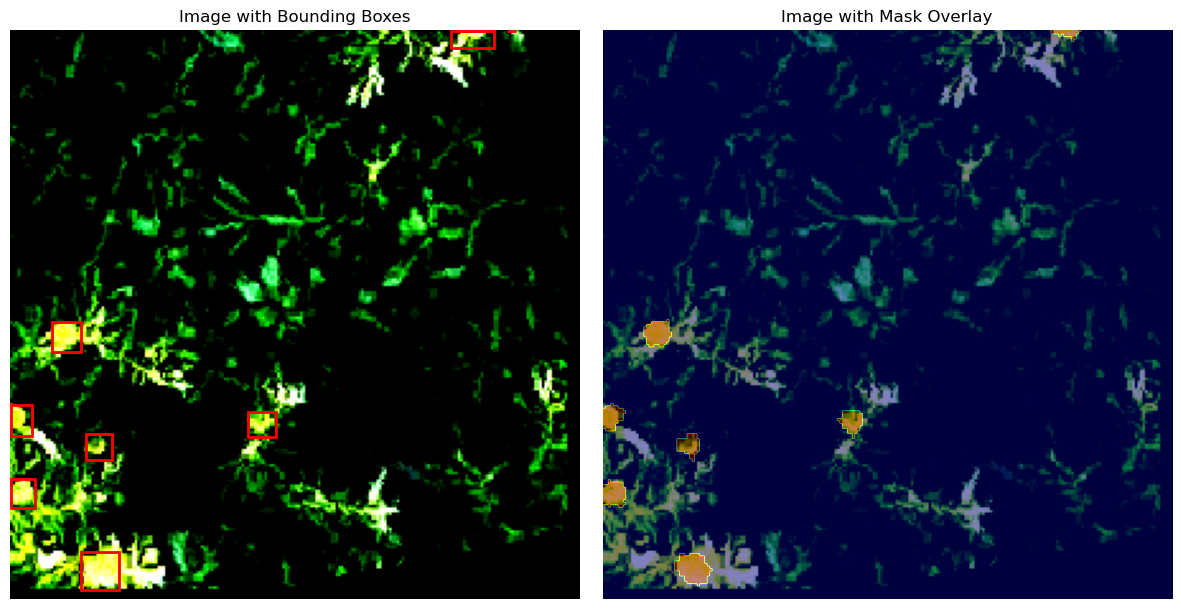

In [7]:
def plot_image_with_annotations(image, target):
    """
    Plot an image with bounding boxes (left) and with an overlayed mask (right).

    Parameters:
      image: tv_tensors.Image wrapping a torch.Tensor of shape [C, H, W]
      target: dictionary with keys "boxes" (BoundingBoxes) and "masks" (Mask)
    """
    # Convert image tensor to numpy image in HxWxC format
    # (Assumes image tensor is already in the proper format, note: normalization is not reversed)
    img_np = image.permute(1, 2, 0).cpu().numpy()
    img_np = np.clip(img_np, 0, 1)

    # Extract bounding boxes from target.
    # Depending on your tv_tensors version, access the underlying tensor via .data or .tensor.
    if hasattr(target["boxes"], "data"):
        boxes = target["boxes"].data
    else:
        boxes = target["boxes"].tensor
    boxes = boxes.cpu().numpy()

    # Extract mask from target.
    if hasattr(target["masks"], "data"):
        mask_tensor = target["masks"].data
    else:
        mask_tensor = target["masks"].tensor
    mask_np = mask_tensor.cpu().numpy()  # shape: (C, H, W)
    # Combine channels if necessary (assumes binary masks per instance)
    if mask_np.ndim == 3:
        combined_mask = np.sum(mask_np, axis=0)
    else:
        combined_mask = mask_np

    # Create figure with two subplots
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # Left: Plot image with bounding boxes
    ax = axes[0]
    ax.imshow(img_np)
    for box in boxes:
        x1, y1, x2, y2 = box
        rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1,
                                 linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
    ax.set_title("Image with Bounding Boxes")
    ax.axis("off")

    # Right: Plot image with mask overlay
    ax = axes[1]
    ax.imshow(img_np)
    ax.imshow(combined_mask, cmap='jet', alpha=0.5)
    ax.set_title("Image with Mask Overlay")
    ax.axis("off")

    plt.tight_layout()
    plt.show()

for i in range(len(images)):
    plot_image_with_annotations(images[i], targets[i])

#### <center> Model Definition </center>

In [8]:
def get_gn(num_channels, num_groups=8):
    return nn.GroupNorm(num_groups=min(num_groups, num_channels), num_channels=num_channels)

def calculate_pos_weight(dataset):
    """Calculate positive weight based on class distribution in dataset"""
    total_pixels = 0
    positive_pixels = 0
    
    for i in range(len(dataset)):
        _, target = dataset[i]
        mask = target['masks']
        total_pixels += mask.numel()
        positive_pixels += mask.sum()
    
    neg_pos_ratio = (total_pixels - positive_pixels) / positive_pixels
    return torch.tensor([neg_pos_ratio])

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, dropout_rate=0.0):
        super(DoubleConv, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            get_gn(out_channels),
            nn.ReLU(inplace=True),
            nn.Dropout2d(p=dropout_rate),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            get_gn(out_channels),
            nn.ReLU(inplace=True),
            nn.Dropout2d(p=dropout_rate)
        )
        
    def forward(self, x):
        return self.double_conv(x)

class AttentionBlock(nn.Module):
    def __init__(self, F_g, F_l, F_int):
        super(AttentionBlock, self).__init__()
        self.W_g = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1),
            get_gn(F_int)
        )
        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1),
            get_gn(F_int)
        )
        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1),
            get_gn(1),
            nn.Sigmoid()
        )
        self.relu = nn.ReLU(inplace=True)
    
    def forward(self, g, x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)
        return x * psi

class UpBlock(nn.Module):
    def __init__(self, in_channels, out_channels, skip_in=None, dropout_rate=0.0):
        super(UpBlock, self).__init__()
        if skip_in is None:
            skip_in = out_channels
        # Replace ConvTranspose2d with Upsampling
        self.up = nn.Sequential(
            nn.UpsamplingBilinear2d(scale_factor=2),
            nn.Conv2d(in_channels, out_channels, kernel_size=1),
            nn.Dropout2d(p=dropout_rate)
        )
        self.skip_reduce = nn.Sequential(
            nn.Conv2d(skip_in, out_channels, kernel_size=1),
            nn.Dropout2d(p=dropout_rate)
        )
        self.attention = AttentionBlock(F_g=out_channels, F_l=out_channels, F_int=out_channels // 2)
        self.conv = DoubleConv(out_channels * 2, out_channels, dropout_rate)
    
    def forward(self, x, skip):
        x = self.up(x)
        skip = self.skip_reduce(skip)
        # Use bicubic interpolation for better resolution preservation
        if x.size() != skip.size():
            x = F.interpolate(x, size=skip.size()[2:], mode='bicubic', align_corners=True)
        skip = self.attention(x, skip)
        x = torch.cat([skip, x], dim=1)
        return self.conv(x)
    
class DiceBCELoss(nn.Module):
    def __init__(self, pos_weight=None, dice_weight=0.5):
        super().__init__()
        self.bce = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
        self.dice_weight = dice_weight
        
    def forward(self, input, target):
        # Calculate individual losses
        bce_loss = self.bce(input, target)
        
        input_sigmoid = torch.sigmoid(input)
        dice_numerator = 2 * (input_sigmoid * target).sum()
        dice_denominator = input_sigmoid.sum() + target.sum()
        dice_loss = 1 - (dice_numerator + 1) / (dice_denominator + 1)
        
        # Apply weights to individual losses
        weighted_bce = (1 - self.dice_weight) * bce_loss
        weighted_dice = self.dice_weight * dice_loss
        
        # Sum weighted losses
        total_loss = weighted_bce + weighted_dice
        
        return {
            'loss': total_loss,
            'bce_loss': weighted_bce.detach(),  # Now contains weighted BCE loss
            'dice_loss': weighted_dice.detach()  # Now contains weighted Dice loss
        }

class SmallObjectUNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, base_filters=64, dataset=None,
                 num_groups=8, grad_clip=1.0, l2_lambda=0.01, pos_weight_multiplier=1.0,
                 dice_weight=0.5, deep_supervision=True, dropout_rate=0.0):
        super().__init__()
        self.encoder = timm.create_model('swin_tiny_patch4_window7_224', pretrained=True, features_only=True)
        encoder_channels = self.encoder.feature_info.channels()
        self.num_groups = num_groups
        self.l2_lambda = l2_lambda
        self.grad_clip = grad_clip
        
        # Calculate positive class weight with multiplier
        base_pos_weight = calculate_pos_weight(dataset) if dataset is not None else torch.tensor([2.0])
        self.pos_weight = base_pos_weight * pos_weight_multiplier
        
        self.center = DoubleConv(encoder_channels[-1], encoder_channels[-1], dropout_rate)
        self.dec4 = UpBlock(encoder_channels[-1], encoder_channels[-2], encoder_channels[-1], dropout_rate)
        self.dec3 = UpBlock(encoder_channels[-2], encoder_channels[-3], encoder_channels[-2], dropout_rate)
        self.dec2 = UpBlock(encoder_channels[-3], encoder_channels[-4], encoder_channels[-3], dropout_rate)
        self.dec1 = UpBlock(encoder_channels[-4], base_filters, encoder_channels[-4], dropout_rate)
        
        # Add final upsampling to match input resolution
        self.out_conv = nn.Sequential(
            nn.UpsamplingBilinear2d(scale_factor=2),
            nn.Conv2d(base_filters, base_filters, kernel_size=3, padding=1),
            get_gn(base_filters),
            nn.ReLU(inplace=True),
            nn.Conv2d(base_filters, out_channels, kernel_size=1)
        )
        
        self._init_weights()

        # Add deep supervision outputs
        self.deep_supervision = deep_supervision
        if deep_supervision:
            self.deep_sup4 = nn.Conv2d(encoder_channels[-2], out_channels, 1)
            self.deep_sup3 = nn.Conv2d(encoder_channels[-3], out_channels, 1)
            self.deep_sup2 = nn.Conv2d(encoder_channels[-4], out_channels, 1)
            self.deep_sup1 = nn.Conv2d(base_filters, out_channels, 1)
        
        # Initialize loss function
        self.criterion = DiceBCELoss(pos_weight=self.pos_weight, dice_weight=dice_weight)

    def forward(self, images, targets=None):
        if isinstance(images, list):
            images = torch.stack(images, dim=0)
            
        features = self.encoder(images)
        e1, e2, e3, e4 = features[0], features[1], features[2], features[3]
        
        # Ensure correct feature shapes
        e1 = self.ensure_channel_first(e1)
        e2 = self.ensure_channel_first(e2)
        e3 = self.ensure_channel_first(e3)
        e4 = self.ensure_channel_first(e4)
        
        center = self.center(e4)
        d4 = self.dec4(center, e4)
        d3 = self.dec3(d4, e3)
        d2 = self.dec2(d3, e2)
        d1 = self.dec1(d2, e1)
        main_pred = self.out_conv(d1)

        if self.training:
            if self.deep_supervision:
                # Get deep supervision predictions
                sup4 = F.interpolate(self.deep_sup4(d4), size=main_pred.shape[2:], mode='bicubic')
                sup3 = F.interpolate(self.deep_sup3(d3), size=main_pred.shape[2:], mode='bicubic')
                sup2 = F.interpolate(self.deep_sup2(d2), size=main_pred.shape[2:], mode='bicubic')
                sup1 = F.interpolate(self.deep_sup1(d1), size=main_pred.shape[2:], mode='bicubic')
                
                # Compute loss for all outputs
                loss_dict = self._compute_loss(main_pred, targets)
                loss_dict['loss'] = loss_dict['loss'] + 0.5 * self._compute_loss(sup4, targets)['loss']
                loss_dict['loss'] = loss_dict['loss'] + 0.3 * self._compute_loss(sup3, targets)['loss']
                loss_dict['loss'] = loss_dict['loss'] + 0.2 * self._compute_loss(sup2, targets)['loss']
                loss_dict['loss'] = loss_dict['loss'] + 0.1 * self._compute_loss(sup1, targets)['loss']
            else:
                loss_dict = self._compute_loss(main_pred, targets)
            return loss_dict
        else:
            pred_masks = torch.sigmoid(main_pred)
            results = []
            for i in range(len(pred_masks)):
                mask = pred_masks[i]
                # Calculate confidence score as mean probability of positive pixels
                # This considers both the presence and strength of predictions
                positive_pixels = (mask > 0.5).float()
                if positive_pixels.sum() > 0:
                    confidence = (mask * positive_pixels).sum() / positive_pixels.sum()
                else:
                    confidence = torch.tensor(0.0, device=mask.device)
                    
                result = {
                    'masks': mask.unsqueeze(0),
                    'scores': confidence.unsqueeze(0),  # Use calculated confidence
                    'labels': torch.tensor([1], device=main_pred.device)
                }
                results.append(result)
            return results

    def _compute_loss(self, predictions, targets):
        combined_masks = []
        for target in targets:
            mask = target['masks']
            if mask.dim() == 3 and mask.shape[0] > 1:
                # Multiple instance masks, take max
                mask = torch.max(mask, dim=0, keepdim=True)[0]
            elif mask.dim() == 2:
                # Single channel mask, add channel dimension
                mask = mask.unsqueeze(0)
            elif mask.shape[0] == 0:
                # No annotations, create zero mask
                mask = torch.zeros((1, mask.shape[1], mask.shape[2]), 
                                device=predictions.device)
            combined_masks.append(mask)
        
        # Now all masks should have shape [1, H, W]
        masks = torch.stack(combined_masks, dim=0).to(predictions.device)
        masks = masks.float()
        
        # Ensure masks have correct shape
        if masks.shape[1] != 1:
            masks = masks[:, 0:1, :, :]
        
        # Resize masks to match predictions
        masks = F.interpolate(masks, size=predictions.shape[2:], 
                            mode='bicubic', align_corners=True)
        
        # Get loss components from criterion
        loss_dict = self.criterion(predictions.view(-1), masks.view(-1))
        
        # Add L2 regularization to the total loss
        l2_reg = torch.tensor(0., device=predictions.device)
        for param in self.parameters():
            l2_reg += torch.norm(param)
        
        # Add L2 regularization to the main loss component
        loss_dict['loss'] = loss_dict['loss'] + self.l2_lambda * l2_reg
        
        if self.training:
            torch.nn.utils.clip_grad_norm_(self.parameters(), self.grad_clip)
        
        return loss_dict
    
    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.GroupNorm):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
    
    def ensure_channel_first(self, x):
        if x.dim() == 4 and x.size(1) not in [1, 3, 96, 192, 384, 768]:
            return x.permute(0, 3, 1, 2).contiguous()
        return x

print(SmallObjectUNet())

SmallObjectUNet(
  (encoder): FeatureListNet(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      (norm): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
    )
    (layers_0): SwinTransformerStage(
      (downsample): Identity()
      (blocks): Sequential(
        (0): SwinTransformerBlock(
          (norm1): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
          (attn): WindowAttention(
            (qkv): Linear(in_features=96, out_features=288, bias=True)
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=96, out_features=96, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
            (softmax): Softmax(dim=-1)
          )
          (drop_path1): Identity()
          (norm2): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_features=96, out_features=384, bias=True)
            (act): GELU(approximate='none')
 

#### <center> Create Train, Val, Test Datasets </center>

In [9]:
# store indices in random order list for subsetting
indices = torch.randperm(len(sample_ds)).tolist()

# Calculate split indices
train_split = int(0.8 * len(indices))
val_split = int(0.95 * len(indices))

train_indices = indices[:train_split]
val_indices = indices[train_split:val_split]
test_indices = indices[val_split:]

#### <center> Tune Model Hyperparameters </center>

In [10]:
import ray
from ray import tune, train
from ray.tune.schedulers import HyperBandForBOHB
from ray.tune.search.bohb import TuneBOHB
from ray.tune.search import ConcurrencyLimiter
from datetime import datetime
import torch
import gc
import tempfile
from pathlib import Path
import ray.cloudpickle as pickle
from concurrent.futures import ThreadPoolExecutor
import random
from torch_lr_finder import LRFinder, TrainDataLoaderIter
from segmentation_pytorch import engine
from segmentation_pytorch.coco_utils import get_coco_api_from_dataset


# Set random seed for reproducible training
def set_seed(seed):
    random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)


def visualize_predictions(model, data_loader, device, epoch, num_samples=2):
    """
    Visualize semantic segmentation predictions.
    Shows input image, ground truth mask, and predicted mask.
    
    Args:
        model: The model to generate predictions
        data_loader: DataLoader to sample images from
        device: Device to run model on
        epoch: Current epoch number
        num_samples: Number of batch samples to visualize
    """
    model.eval()
    
    with torch.no_grad():
        for i, (images, targets) in enumerate(data_loader):
            if i >= num_samples:
                break
                
            images = list(img.to(device) for img in images)
            outputs = model(images)
            
            for b in range(len(images)):
                # Get original image
                img = images[b].cpu()
                
                # Get ground truth mask [1, H, W]
                gt_mask = targets[b]['masks']
                
                # Get predicted mask and confidence score
                pred_mask = outputs[b]['masks']
                pred_score = outputs[b]['scores'][0].item()  # Get the prediction score
                
                # Create figure
                fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
                
                # Plot original image
                ax1.imshow(img.permute(1, 2, 0))
                ax1.set_title(f'Input Image\nEpoch {epoch}, Batch {i}')
                ax1.axis('off')
                
                # Plot ground truth mask
                ax2.imshow(gt_mask.squeeze(), cmap='gray')
                ax2.set_title(f'Ground Truth\nPositive pixels: {gt_mask.sum():.0f}')
                ax2.axis('off')
                
                # Plot prediction
                ax3.imshow(pred_mask.squeeze().cpu(), cmap='gray')
                ax3.set_title(f'Prediction\nConfidence Score: {pred_score:.3f}')
                ax3.axis('off')
                
                plt.tight_layout()
                plt.show()
                plt.close()


def calculate_f1_score(precision, recall):
    if precision + recall == 0:
        return 0.0
    return 2 * (precision * recall) / (precision + recall)


def is_plateaued(values, tolerance=0.0005):
    """
    Check if values have plateaued by comparing max and min
    in the window to see if they're within tolerance
    """
    if len(values) < 5:  # Need at least 5 values to determine plateau
        return False
    recent_values = values[-5:]  # Look at last 5 epochs
    max_val, min_val = max(recent_values), min(recent_values)
    return (max_val - min_val) < tolerance


def train_lr_finder(batch_size):

    class CustomTrainDataLoaderIter(TrainDataLoaderIter):
        def inputs_labels_from_batch(self, batch_data):
            inputs = [image.to('cuda:0') if isinstance(image, torch.Tensor) else torch.tensor(image).to('cuda:0') for image in batch_data[0]]
            labels = [{k: v.to('cuda:0') if isinstance(v, torch.Tensor) else torch.tensor(v).to('cuda:0') for k, v in t.items()} for t in batch_data[1]]
            return inputs, labels

    dataset_train = ChestnutBurSegmentation(images_dir, 
                                      masks_dir, 
                                      annotations_csv,
                                      transform = get_transform(train=True))
    dataset_train = Subset(dataset_train, train_indices)

    accumulation_steps = 1  ## FIXME: hardcoded for now

    data_loader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size,
                                                    shuffle=True,
                                                    collate_fn=ChestnutBurSegmentation.collate_fn,
                                                    num_workers=0, pin_memory=False)

    model = SmallObjectUNet(in_channels=3, out_channels=1, base_filters=64, dataset=dataset_train)

    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.Adam(params, lr=1e-7)

    train_iter = CustomTrainDataLoaderIter(data_loader_train)
    grad_scaler = torch.GradScaler()

    class CustomLRFinder(LRFinder):
        def __init__(self, model, optimizer, criterion, device=None, amp_backend="native", amp_config=None, grad_scaler=None):
            super().__init__(model, optimizer, criterion, device)
            self.amp_backend = amp_backend
            self.amp_config = amp_config
            self.grad_scaler = grad_scaler or torch.GradScaler()

        def _train_batch(self, train_iter, accumulation_steps, non_blocking_transfer=True):
            self.model.train()
            total_loss = 0

            self.optimizer.zero_grad()
            for _ in range(accumulation_steps):
                inputs, labels = next(train_iter)
                inputs, labels = self._move_to_device(inputs, labels, non_blocking=non_blocking_transfer)

                with torch.autocast(device_type="cuda:0"):
                    outputs = self.model(inputs, labels)
                    loss = sum(loss for loss in outputs.values())

                loss /= accumulation_steps
                self.grad_scaler.scale(loss).backward()
                total_loss += loss

            self.grad_scaler.step(self.optimizer)
            self.grad_scaler.update()

            return total_loss.item()

    lr_finder = CustomLRFinder(model, optimizer, None, device='cuda:0', amp_backend='torch', amp_config=None, grad_scaler=grad_scaler)
    lr_finder.range_test(train_iter, end_lr=0.01, num_iter=500, step_mode='exp', accumulation_steps=accumulation_steps)
    suggested_lr = lr_finder.plot(suggest_lr=True)

    lr_finder.reset()

    # Ensure consistent return value
    try:
        if isinstance(suggested_lr, tuple):
            axes, suggested_lr_value = suggested_lr
            return suggested_lr_value
        else:
            raise ValueError(f"Unexpected return type from plot method: {type(suggested_lr)}")
    except ValueError as e:
        print(f"Error during learning rate finding: {e}")
        # Return a default learning rate if an error occurs
        return 5e-4

In [11]:
class SmallObjectUNetTuner:
    def __init__(self, num_samples, restore_path=""):
        self.num_samples = num_samples
        self.restore_path = restore_path

    def create_coco_datasets(self, train_dataset, val_dataset, test_dataset):
        with ThreadPoolExecutor(max_workers=3) as executor:
            train_future = executor.submit(get_coco_api_from_dataset, train_dataset)
            val_future = executor.submit(get_coco_api_from_dataset, val_dataset)
            test_future = executor.submit(get_coco_api_from_dataset, test_dataset)
            train_coco_ds = train_future.result()
            val_coco_ds = val_future.result()
            test_coco_ds = test_future.result()
        return train_coco_ds, val_coco_ds, test_coco_ds

    def train_SmallObjectUNet(self, config):

        set_seed(666)

        dataset = ray.get(config["dataset_train_ref"])
        data_loader_val = ray.get(config["data_loader_val_ref"])
        train_coco_ds = ray.get(config["train_coco_ds_ref"])
        val_coco_ds = ray.get(config["val_coco_ds_ref"])

        training_steps = [
            {"step": 0, "batch_size": 4, "print_freq": 50, "accumulation_steps": 1},
            {"step": 1, "batch_size": 8, "print_freq": 25, "accumulation_steps": 1},
            {"step": 2, "batch_size": 16, "print_freq": 15, "accumulation_steps": 1},
            {"step": 3, "batch_size": 32, "print_freq": 5, "accumulation_steps": 1},
            {"step": 4, "batch_size": 32, "print_freq": 5, "accumulation_steps": 2},
            {"step": 5, "batch_size": 32, "print_freq": 5, "accumulation_steps": 4},
            {"step": 6, "batch_size": 32, "print_freq": 5, "accumulation_steps": 8},
            {"step": 7, "batch_size": 32, "print_freq": 5, "accumulation_steps": 16} # bs 512
        ]

        device = "cpu"
        if torch.cuda.is_available():
            device = "cuda:0"

        checkpoint = train.get_checkpoint()
        if checkpoint:
            with checkpoint.as_directory() as checkpoint_dir:
                data_path = Path(checkpoint_dir) / "data.pkl"
                with open(data_path, "rb") as fp:
                    checkpoint_state = pickle.load(fp)
                start_epoch = checkpoint_state["epoch"] + 1
                step_index = checkpoint_state["step_index"]
        else:
            start_epoch = 0
            step_index = 0

        # Loop through training_steps during training to increase batch size and decrease learning rate
        while step_index < len(training_steps):
            ts = training_steps[step_index]
            batch_size, print_freq, accumulation_steps = ts["batch_size"], ts["print_freq"], ts["accumulation_steps"]
            scaled_lr = config["lr"] * (batch_size / training_steps[0]["batch_size"]) * accumulation_steps

            # Reinitialize the model with the current hyperparameters
            model = SmallObjectUNet(in_channels=3,
                                    out_channels=1,
                                    base_filters=config["base_filters"],
                                    dataset=dataset,
                                    num_groups=config["num_groups"],
                                    grad_clip=config["grad_clip"],
                                    l2_lambda=config["l2_lambda"],
                                    pos_weight_multiplier=config["pos_weight_multiplier"],
                                    dice_weight=config["dice_weight"],
                                    deep_supervision=config["deep_supervision"],
                                    dropout_rate=config["dropout_rate"]
            )

            model.to(device)

            # Construct an optimizer with the suggested learning rate
            params = [p for p in model.parameters() if p.requires_grad]
            optimizer = torch.optim.Adam(params, 
                                         lr=scaled_lr,
                                         betas=(config["beta1_loss"], config["beta2_loss"]),
                                         eps=config["epsilon_loss"],)

            # Define training and validation data loaders
            data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, 
                                                    shuffle=False, 
                                                    collate_fn=ChestnutBurSegmentation.collate_fn, 
                                                    num_workers=0,
                                                    pin_memory=True)
            
            print(f'Training step: {ts["step"]}, effective batch size: {batch_size * accumulation_steps}, scaled lr: {scaled_lr:.6f}\n')
            print()

            window_loss, window_f1 = [], []
            window_size = 5
            plateau_tolerance = 0.0001
            minimum_step_epochs = 10
            step_epoch_counter = 0

            while True:
                step_epoch_counter += 1

                train_metric_logger, val_metric_logger = engine.train_one_epoch(
                    model, optimizer, data_loader, device,
                    start_epoch, print_freq, accumulation_steps,
                    data_loader_val
                )

                train_coco_evaluator, val_coco_evaluator = engine.evaluate(
                    model, data_loader_val, val_coco_ds, device, data_loader, train_coco_ds
                )

                # Add visualization for monitoring validation predictions
                if start_epoch % 10 == 0:  # Visualize every 5 epochs
                    visualize_predictions(model, data_loader_val, device, start_epoch)

                current_val_f1 = calculate_f1_score(val_coco_evaluator.coco_eval['segm'].stats[0],
                                                      val_coco_evaluator.coco_eval['segm'].stats[6])
                current_val_loss = val_metric_logger.loss.avg

                window_loss.append(current_val_loss)
                window_f1.append(current_val_f1)
                if len(window_loss) > window_size:
                    window_loss.pop(0)
                if len(window_f1) > window_size:
                    window_f1.pop(0)

                if step_epoch_counter >= minimum_step_epochs and len(window_loss) == window_size:
                    loss_plateaued = is_plateaued(window_loss, tolerance=plateau_tolerance)
                    f1_plateaued = is_plateaued(window_f1, tolerance=plateau_tolerance)
                    
                    if loss_plateaued or f1_plateaued:
                        print(f"{'Loss' if loss_plateaued else 'F1'} plateaued after {step_epoch_counter} epochs")
                        print(f"Recent losses: {window_loss}")
                        print(f"Recent F1 scores: {window_f1}")
                        start_epoch += 1
                        print("Moving to next training step.")
                        break


                checkpoint_data = {
                    "epoch": start_epoch,
                    "step_index": step_index,
                    "training_iteration": step_epoch_counter,
                    "model_state_dict": model.state_dict(),
                    "optimizer_state_dict": optimizer.state_dict(),
                }

                with tempfile.TemporaryDirectory() as checkpoint_dir:
                    data_path = Path(checkpoint_dir) / "data.pkl"
                    with open(data_path, "wb") as fp:
                        pickle.dump(checkpoint_data, fp)
                    train.report(
                        {
                            "epoch": start_epoch,
                            "step_index": step_index,
                            "training_iteration": step_epoch_counter,
                            "train_loss": train_metric_logger.loss.avg,
                            "val_loss": val_metric_logger.loss.avg,
                            "train_mAP": train_coco_evaluator.coco_eval['segm'].stats[0],
                            "val_mAP": val_coco_evaluator.coco_eval['segm'].stats[0],
                            "train_mAR": train_coco_evaluator.coco_eval['segm'].stats[6],
                            "val_mAR": val_coco_evaluator.coco_eval['segm'].stats[6],
                            "train_f1": calculate_f1_score(train_coco_evaluator.coco_eval['segm'].stats[0],
                                                            train_coco_evaluator.coco_eval['segm'].stats[6]),
                            "val_f1": current_val_f1
                        },
                        checkpoint=train.Checkpoint.from_directory(checkpoint_dir),
                    )

                start_epoch += 1

            step_index += 1

        print('Tuning Trial Complete!')

    def trial_dirname_creator(self, trial):
        return f"{trial.trial_id}"

    def run(self):
        ray.shutdown()
        ray.init()

        dataset = ChestnutBurSegmentation(images_dir, 
                                      masks_dir, 
                                      annotations_csv,
                                      transform = get_transform(train=True)
        )
    
        dataset_val = ChestnutBurSegmentation(images_dir,
                                            masks_dir,
                                            annotations_csv,
                                            transform = get_transform(train=False)
        )

        dataset_test = ChestnutBurSegmentation(images_dir,
                                            masks_dir,
                                            annotations_csv,
                                            transform = get_transform(train=False)
        )

        dataset_train = torch.utils.data.Subset(dataset, train_indices)
        dataset_val = torch.utils.data.Subset(dataset_val, val_indices)
        dataset_test = torch.utils.data.Subset(dataset_test, test_indices)

        data_loader_val = torch.utils.data.DataLoader(
            dataset_val, batch_size=1, shuffle=False,
            collate_fn=ChestnutBurSegmentation.collate_fn, num_workers=0, pin_memory=True
        )

        data_loader_test = torch.utils.data.DataLoader(
            dataset_test, batch_size=1, shuffle=False,
            collate_fn=ChestnutBurSegmentation.collate_fn, num_workers=0, pin_memory=True
        )

        train_coco_ds, val_coco_ds, test_coco_ds = self.create_coco_datasets(dataset_train, dataset_val, dataset_test)

        dataset_train_ref = ray.put(dataset_train)
        data_loader_val_ref = ray.put(data_loader_val)
        data_loader_test_ref = ray.put(data_loader_test)
        train_coco_ds_ref = ray.put(train_coco_ds)
        val_coco_ds_ref = ray.put(val_coco_ds)
        test_coco_ds_ref = ray.put(test_coco_ds)

        config = {
            # Model architecture
            "base_filters": tune.choice([16, 32, 64, 128]),  # Base number of filters
            "num_groups": tune.choice([4, 8, 16, 32]),  # Groups in GroupNorm layers
            "deep_supervision": tune.choice([True, False]),  # Enable/disable deep supervision
            
            # Training parameters
            "lr": tune.loguniform(1e-6, 1e-1),
            
            # Regularization
            "l2_lambda": tune.loguniform(1e-6, 1e-1),  # L2 regularization strength
            "grad_clip": tune.uniform(0.25, 2.5),  # Gradient clipping threshold
            "dropout_rate": tune.uniform(0.1, 0.9),  # Dropout rate
            
            # Loss function
            "pos_weight_multiplier": tune.uniform(0.0, 5.0),  # Multiplier for calculated pos_weight
            "dice_weight": tune.uniform(0.1, 0.9),  # Weight for Dice Loss
    
            
            # Optimizer parameters
            "beta1_loss": tune.uniform(0.9, 0.9999),
            "beta2_loss": tune.uniform(0.99, 0.99999),
            "epsilon_loss": tune.loguniform(1e-8, 1e-4),

            # References to data loaders and datasets
            "dataset_train_ref": dataset_train_ref,
            "data_loader_val_ref": data_loader_val_ref,
            "data_loader_test_ref": data_loader_test_ref,
            "train_coco_ds_ref": train_coco_ds_ref,
            "val_coco_ds_ref": val_coco_ds_ref,
            "test_coco_ds_ref": test_coco_ds_ref
        }

        if tune.Tuner.can_restore(os.path.abspath(self.restore_path)):
            tuner = tune.Tuner.restore(
                os.path.abspath(self.restore_path),
                trainable=self.train_SmallObjectUNet,
                param_space=config,
                resume_unfinished=True,
                resume_errored=False
            )
            print(f"Tuner Restored from {self.restore_path}")
        else:
            algo = TuneBOHB(
                seed=666
            )

            algo = ConcurrencyLimiter(algo, max_concurrent=2)

            scheduler = HyperBandForBOHB(
                time_attr="training_iteration",
                reduction_factor=4,
                stop_last_trials=False,
            )

            reporter = tune.JupyterNotebookReporter(overwrite=True,
                metric_columns=["epoch", "step_index", "training_iteration", "train_loss", "val_loss", "train_mAP", "val_mAP", "train_mAR", "val_mAR", "train_f1", "val_f1"],
                parameter_columns=["lr", "base_filters", "num_groups", "l2_lambda", "grad_clip", "pos_weight_multiplier", "beta1_loss", "beta2_loss", "epsilon_loss"],
                print_intermediate_tables=True,
                sort_by_metric=True
            )

            tuner = tune.Tuner(
                tune.with_resources(
                    self.train_SmallObjectUNet,
                    resources={"cpu": 12.0, "gpu": 1.0}
                ),
                run_config=train.RunConfig(
                    name=f"BOHB_SmallObjectUNet_{datetime.now().strftime('%Y%m%d_%H%M%S')}",
                    failure_config=train.FailureConfig(max_failures=1),
                    progress_reporter=reporter,
                ),
                tune_config=tune.TuneConfig(
                    mode="min",
                    metric="val_loss",
                    search_alg=algo,
                    scheduler=scheduler,
                    num_samples=int(self.num_samples),
                    trial_dirname_creator=self.trial_dirname_creator
                ),
                param_space=config
            )
        results = tuner.fit()

        best_trial = results.get_best_result("val_loss", "min")

        print("Best trial config: {}".format(best_trial.config))
        print()
        print("Best trial final training loss: {}".format(best_trial.metrics["train_loss"]))
        print("Best trial final validation loss: {}".format(best_trial.metrics["val_loss"]))
        print("Best trial final training mAP: {}".format(best_trial.metrics["train_mAP"]))
        print("Best trial final validation mAP: {}".format(best_trial.metrics["val_mAP"]))
        print("Best trial final training mAR: {}".format(best_trial.metrics["train_mAR"]))
        print("Best trial final validation mAR: {}".format(best_trial.metrics["val_mAR"]))
        print("Best trial final training f1-score: {}".format(best_trial.metrics["train_f1"]))
        print("Best trial final validation f1-score: {}".format(best_trial.metrics["val_f1"]))
        
        print()

        best_checkpoint = best_trial.get_best_checkpoint(metric="val_f1", mode="max")

        self.test_best_model(best_trial, best_checkpoint)

        return train_coco_ds, val_coco_ds, test_coco_ds, results, best_trial

    def test_best_model(self, best_trial, best_checkpoint):
        best_model = SmallObjectUNet(in_channels=3,
                                    out_channels=1,
                                    base_filters=best_trial.config["base_filters"],
                                    dataset=ray.get(best_trial.config["dataset_train_ref"]),
                                    num_groups=best_trial.config["num_groups"],
                                    grad_clip=best_trial.config["grad_clip"],
                                    l2_lambda=best_trial.config["l2_lambda"],
                                    pos_weight_multiplier=best_trial.config["pos_weight_multiplier"]
        )

        device = "cpu"
        if torch.cuda.is_available():
            device = "cuda:0"
        best_model.to(device)

        with best_checkpoint.as_directory() as checkpoint_dir:
            data_path = Path(checkpoint_dir) / "data.pkl"
            with open(data_path, "rb") as fp:
                best_checkpoint_data = pickle.load(fp)
            best_model.load_state_dict(best_checkpoint_data["model_state_dict"])

        data_loader_test = ray.get(best_trial.config["data_loader_test_ref"])
        test_coco_ds = ray.get(best_trial.config["test_coco_ds_ref"])

        test_results = engine.evaluate(best_model, data_loader_test, test_coco_ds, device, train_data_loader=None, train_coco_ds=None)

        print(f'Best trial test set mAP: {test_results.coco_eval["segm"].stats[0]}')
        print(f'Best trial test set mAR: {test_results.coco_eval["segm"].stats[6]}')
        print(f'Best trial test set f1-score: {calculate_f1_score(test_results.coco_eval["segm"].stats[0], test_results.coco_eval["segm"].stats[6])}')

# if __name__ == "__main__":
#     torch.cuda.empty_cache()
#     gc.collect()

#     trainer = SmallObjectUNetTuner(num_samples=100, restore_path="C:/Users/zack/ray_results/FALSE")
#     train_coco_ds, val_coco_ds, test_coco_ds, results, best_trial = trainer.run()

#### <center> Train Model with Best Hyperparameter Combination </center>

  0%|          | 0/500 [00:00<?, ?it/s]

c:\Users\zack\anaconda3\envs\bohb_pt\lib\site-packages\torch\optim\lr_scheduler.py:224: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 8.51E-03


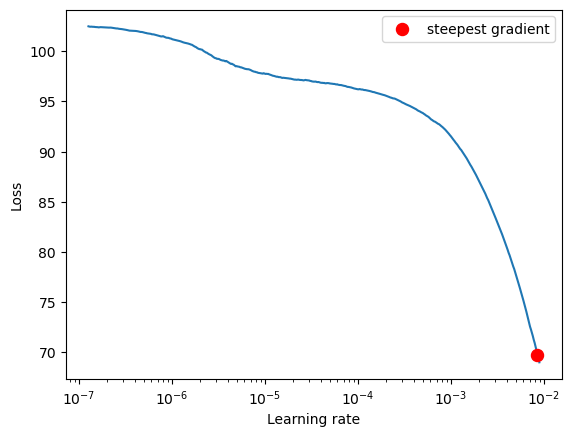

creating index...
index created!
creating index...
index created!


In [ ]:
from torch.utils.tensorboard import SummaryWriter
import torch.profiler

def main():
    
    # Set seed
    set_seed(666)

    training_steps = [
        {"step": 0, "batch_size": 4, "print_freq": 50, "accumulation_steps": 1},
        {"step": 1, "batch_size": 8, "print_freq": 25, "accumulation_steps": 1},
        {"step": 2, "batch_size": 16, "print_freq": 15, "accumulation_steps": 1},
        {"step": 3, "batch_size": 32, "print_freq": 5, "accumulation_steps": 1},
        {"step": 4, "batch_size": 32, "print_freq": 5, "accumulation_steps": 2},
        {"step": 5, "batch_size": 32, "print_freq": 5, "accumulation_steps": 4},
        {"step": 6, "batch_size": 32, "print_freq": 5, "accumulation_steps": 8},
        {"step": 7, "batch_size": 32, "print_freq": 5, "accumulation_steps": 16} # bs 512
    ]

    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda:0"

    # Initialize the tensorboard writer
    current_datetime = datetime.now().strftime("%Y%m%d-%H%M%S")
    writer = SummaryWriter(log_dir=f'C:/Users/zack/Documents/GitHub/Savanna-Institute/Drone-based_Chestnut_Detection/runs/UNet/{current_datetime}')

    # Store one checkpoint dictionary for each epoch in a list of dictionaries. 
    checkpoints = []

    # Initialize the profiler
    profiler = torch.profiler.profile(
        activities=[
            torch.profiler.ProfilerActivity.CPU,
            torch.profiler.ProfilerActivity.CUDA,
        ],
        schedule=torch.profiler.schedule(
            wait=1,
            warmup=1,
            active=3,
            repeat=2),
        on_trace_ready=torch.profiler.tensorboard_trace_handler(dir_name = f'C:/Users/zack/Documents/GitHub/Savanna-Institute/Drone-based_Chestnut_Detection/runs/UNet_profiler/{current_datetime}'),
        record_shapes=True,
        profile_memory=True,
        with_stack=True
    )

    dataset = ChestnutBurSegmentation(images_dir, 
                                      masks_dir, 
                                      annotations_csv,
                                      transform = get_transform(train=True))
    
    dataset_val = ChestnutBurSegmentation(images_dir,
                                          masks_dir,
                                          annotations_csv,
                                          transform = get_transform(train=False))

    dataset = Subset(dataset, train_indices)
    dataset_val = Subset(dataset_val, val_indices)                                  
    
    data_loader_val = torch.utils.data.DataLoader(
        dataset_val, batch_size=1, shuffle=False,
        collate_fn=ChestnutBurSegmentation.collate_fn, num_workers=0, pin_memory=True
    )
    
    start_epoch, step_index = 0, 0

    # Find the optimal learning rate
    suggested_lr = train_lr_finder(batch_size=training_steps[0]["batch_size"])


    train_coco_ds, val_coco_ds = get_coco_api_from_dataset(dataset), get_coco_api_from_dataset(dataset_val)

    # Loop through training_steps during training to increase batch size and decrease learning rate
    while step_index < len(training_steps):
        ts = training_steps[step_index]
        batch_size, print_freq, accumulation_steps = ts["batch_size"], ts["print_freq"], ts["accumulation_steps"]
        scaled_lr = suggested_lr * (batch_size / training_steps[0]["batch_size"]) * accumulation_steps

        # Reinitialize the model with the current hyperparameters
        model = SmallObjectUNet(in_channels=3, 
                                out_channels=1, 
                                base_filters=64, 
                                dataset=dataset,
                                num_groups=8,
                                grad_clip=1.0,
                                l2_lambda=0.01,
                                pos_weight_multiplier=1,
                                dice_weight=0.5,
                                deep_supervision=True,
                                dropout_rate=0)

        model.to(device)

        # Construct an optimizer with the suggested learning rate
        params = [p for p in model.parameters() if p.requires_grad]
        optimizer = torch.optim.Adam(params, 
                                     lr=scaled_lr,
                                     betas=(0.9, 0.999),
                                     eps=1e-8)

        # Define training and validation data loaders
        data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, 
                                                  shuffle=False, 
                                                  collate_fn=ChestnutBurSegmentation.collate_fn, 
                                                  num_workers=0,
                                                  pin_memory=True)
        
        print(f'Training step: {ts["step"]}, effective batch size: {batch_size * accumulation_steps}, scaled lr: {scaled_lr:.6f}\n')

        window_loss, window_f1 = [], []
        window_size = 5
        plateau_tolerance = 0.0001
        minimum_step_epochs = 10
        step_epoch_counter = 0

        #########################################################
        ##               The main training loop                ## 
        #########################################################
        with profiler:
            while True:
                step_epoch_counter += 1
                # Monitor memory usage at the start of the epoch
                print(f"Epoch {start_epoch} - Memory allocated: {torch.cuda.memory_allocated(device)} bytes")

                train_metric_logger, val_metric_logger = engine.train_one_epoch(model, optimizer, data_loader, device, 
                                                                                start_epoch, print_freq, accumulation_steps,
                                                                                data_loader_val)

                # Evaluate on the validation dataset
                train_coco_evaluator, val_coco_evaluator = engine.evaluate(model, data_loader_val, val_coco_ds, device,
                                                                            data_loader, train_coco_ds)
                
                # Add visualization for monitoring validation predictions
                if start_epoch % 5 == 0:  # Visualize every 5 epochs
                    visualize_predictions(model, data_loader_val, device, start_epoch, num_samples=3)
                
                current_val_f1 = calculate_f1_score(val_coco_evaluator.coco_eval['segm'].stats[0],
                                                      val_coco_evaluator.coco_eval['segm'].stats[6])
                current_val_loss = val_metric_logger.loss.avg

                window_loss.append(current_val_loss)
                window_f1.append(current_val_f1)
                if len(window_loss) > window_size:
                    window_loss.pop(0)
                if len(window_f1) > window_size:
                    window_f1.pop(0)

                if step_epoch_counter >= minimum_step_epochs and len(window_loss) == window_size:
                    loss_plateaued = is_plateaued(window_loss, tolerance=plateau_tolerance)
                    f1_plateaued = is_plateaued(window_f1, tolerance=plateau_tolerance)
                    
                    if loss_plateaued or f1_plateaued:
                        print(f"{'Loss' if loss_plateaued else 'F1'} plateaued after {step_epoch_counter} epochs")
                        print(f"Recent losses: {window_loss}")
                        print(f"Recent F1 scores: {window_f1}")
                        start_epoch += 1
                        print("Moving to next training step.")
                        break

                # Store training and validation metrics in checkpoint dictionary. 
                checkpoint = {
                    "epoch": start_epoch,
                    "step_index": step_index,
                    "train_loss": train_metric_logger.loss.avg, # average across entire training epoch
                    "val_loss": val_metric_logger.loss.avg,
                    "train_mAP": train_coco_evaluator.coco_eval['segm'].stats[0],# IoU=0.50:0.95
                    "val_mAP": val_coco_evaluator.coco_eval['segm'].stats[0],
                    "train_mAR": train_coco_evaluator.coco_eval['segm'].stats[6],# IoU=0.50:0.95
                    "val_mAR": val_coco_evaluator.coco_eval['segm'].stats[6],
                    "train_f1": calculate_f1_score(train_coco_evaluator.coco_eval['segm'].stats[0], 
                                                    train_coco_evaluator.coco_eval['segm'].stats[6]
                                                    ),
                    "val_f1": calculate_f1_score(val_coco_evaluator.coco_eval['segm'].stats[0],
                                                    val_coco_evaluator.coco_eval['segm'].stats[6]
                                                    ),
                    "model_state_dict": model.state_dict(),
                    "optimizer_state_dict": optimizer.state_dict()
                }

                # Append checkpoint to checkpoints list
                checkpoints.append(checkpoint)

                # Report training and validation scalars to tensorboard
                writer.add_scalar('Learning_Rate', optimizer.param_groups[0]['lr'], checkpoint['epoch'])
                writer.add_scalar('Segmentation Loss/Train', np.array(float(checkpoint["train_loss"])), checkpoint["epoch"]) # use tags to group scalars
                writer.add_scalar('Segmentation Loss/Val', np.array(float(checkpoint["val_loss"])), checkpoint["epoch"])
                writer.add_scalar('Segmentation mAP/Train', np.array(float(checkpoint["train_mAP"])), checkpoint["epoch"])
                writer.add_scalar('Segmentation mAP/Val', np.array(float(checkpoint["val_mAP"])), checkpoint["epoch"])
                writer.add_scalar('Segmentation mAR/Train', np.array(float(checkpoint["train_mAR"])), checkpoint["epoch"])
                writer.add_scalar('Segmentation mAR/Val', np.array(float(checkpoint["val_mAR"])), checkpoint["epoch"])
                writer.add_scalar('Segmentation F1/Train', np.array(float(checkpoint["train_f1"])), checkpoint["epoch"])
                writer.add_scalar('Segmentation F1/Val', np.array(float(checkpoint["val_f1"])), checkpoint["epoch"])

                # Clear CUDA cache and collect garbage 
                torch.cuda.empty_cache()
                gc.collect()
                print(f"Epoch {start_epoch} - Max memory allocated: {torch.cuda.max_memory_allocated(device)} bytes")
                start_epoch += 1

        step_index += 1

    print('All Training Steps Complete!')
    writer.close()
    return checkpoints

if __name__ == "__main__":
    torch.cuda.empty_cache()
    gc.collect()
    
    checkpoints = main()

In [ ]:
from torch.utils.tensorboard import SummaryWriter
import torch.profiler

def main(train_coco_ds, val_coco_ds, best_trial):

    print(best_trial.config)
    
    # Set seed
    set_seed(666)

    training_steps = [
        {"step": 0, "batch_size": 4, "print_freq": 50, "accumulation_steps": 1},
        {"step": 1, "batch_size": 8, "print_freq": 25, "accumulation_steps": 1},
        {"step": 2, "batch_size": 16, "print_freq": 15, "accumulation_steps": 1},
        {"step": 3, "batch_size": 32, "print_freq": 5, "accumulation_steps": 1},
        {"step": 4, "batch_size": 32, "print_freq": 5, "accumulation_steps": 2},
        {"step": 5, "batch_size": 32, "print_freq": 5, "accumulation_steps": 4},
        {"step": 6, "batch_size": 32, "print_freq": 5, "accumulation_steps": 8},
        {"step": 7, "batch_size": 32, "print_freq": 5, "accumulation_steps": 16} # bs 512
    ]

    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda:0"

    # Initialize the tensorboard writer
    current_datetime = datetime.now().strftime("%Y%m%d-%H%M%S")
    writer = SummaryWriter(log_dir=f'C:/Users/zack/Documents/GitHub/Savanna-Institute/Drone-based_Chestnut_Detection/runs/UNet/{current_datetime}')

    # Store one checkpoint dictionary for each epoch in a list of dictionaries. 
    checkpoints = []

    # Initialize the profiler
    profiler = torch.profiler.profile(
        activities=[
            torch.profiler.ProfilerActivity.CPU,
            torch.profiler.ProfilerActivity.CUDA,
        ],
        schedule=torch.profiler.schedule(
            wait=1,
            warmup=1,
            active=3,
            repeat=2),
        on_trace_ready=torch.profiler.tensorboard_trace_handler(dir_name = f'C:/Users/zack/Documents/GitHub/Savanna-Institute/Drone-based_Chestnut_Detection/runs/UNet_profiler/{current_datetime}'),
        record_shapes=True,
        profile_memory=True,
        with_stack=True
    )

    dataset = ChestnutBurSegmentation(images_dir, 
                                      masks_dir, 
                                      annotations_csv,
                                      transform = get_transform(train=True))
    
    dataset_val = ChestnutBurSegmentation(images_dir,
                                          masks_dir,
                                          annotations_csv,
                                          transform = get_transform(train=False))

    dataset = Subset(dataset, train_indices)
    dataset_val = Subset(dataset_val, val_indices)                                  
    
    data_loader_val = torch.utils.data.DataLoader(
        dataset_val, batch_size=1, shuffle=False,
        collate_fn=ChestnutBurSegmentation.collate_fn, num_workers=0, pin_memory=True
    )
    
    start_epoch, step_index = 0, 0

    # Loop through training_steps during training to increase batch size and decrease learning rate
    while step_index < len(training_steps):
        ts = training_steps[step_index]
        batch_size, print_freq, accumulation_steps = ts["batch_size"], ts["print_freq"], ts["accumulation_steps"]
        scaled_lr = best_trial.config["lr"] * (batch_size / training_steps[0]["batch_size"]) * accumulation_steps

        # Reinitialize the model with the current hyperparameters
        model = SmallObjectUNet(in_channels=3,
                                out_channels=1,
                                base_filters=best_trial.config["base_filters"],
                                dataset=dataset,
                                num_groups=best_trial.config["num_groups"],
                                grad_clip=best_trial.config["grad_clip"],
                                l2_lambda=best_trial.config["l2_lambda"],
                                pos_weight_multiplier=best_trial.config["pos_weight_multiplier"],
                                dice_weight=best_trial.config["dice_weight"],
                                deep_supervision=best_trial.config["deep_supervision"],
                                dropout_rate=best_trial.config["dropout_rate"]
            )

        model.to(device)

        # Construct an optimizer with the suggested learning rate
        params = [p for p in model.parameters() if p.requires_grad]
        optimizer = torch.optim.Adam(params, 
                                     lr=scaled_lr,
                                     betas=(best_trial.config["beta1_loss"], best_trial.config["beta2_loss"]),
                                     eps=best_trial.config["epsilon_loss"])

        # Define training and validation data loaders
        data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, 
                                                  shuffle=False, 
                                                  collate_fn=ChestnutBurSegmentation.collate_fn, 
                                                  num_workers=0,
                                                  pin_memory=True)
        
        print(f'Training step: {ts["step"]}, effective batch size: {batch_size * accumulation_steps}, scaled lr: {scaled_lr:.6f}\n')

        window_loss, window_f1 = [], []
        window_size = 5
        plateau_tolerance = 0.0001
        minimum_step_epochs = 10
        step_epoch_counter = 0

        #########################################################
        ##               The main training loop                ## 
        #########################################################
        with profiler:
            while True:
                step_epoch_counter += 1
                # Monitor memory usage at the start of the epoch
                print(f"Epoch {start_epoch} - Memory allocated: {torch.cuda.memory_allocated(device)} bytes")

                train_metric_logger, val_metric_logger = engine.train_one_epoch(model, optimizer, data_loader, device, 
                                                                                start_epoch, print_freq, accumulation_steps,
                                                                                data_loader_val)

                # Evaluate on the validation dataset
                train_coco_evaluator, val_coco_evaluator = engine.evaluate(model, data_loader_val, val_coco_ds, device,
                                                                            data_loader, train_coco_ds)
                
                # Add visualization for monitoring validation predictions
                if start_epoch % 10 == 0:  # Visualize every 5 epochs
                    visualize_predictions(model, data_loader_val, device, start_epoch)
                
                current_val_f1 = calculate_f1_score(val_coco_evaluator.coco_eval['segm'].stats[0],
                                                      val_coco_evaluator.coco_eval['segm'].stats[6])
                current_val_loss = val_metric_logger.loss.avg

                window_loss.append(current_val_loss)
                window_f1.append(current_val_f1)
                if len(window_loss) > window_size:
                    window_loss.pop(0)
                if len(window_f1) > window_size:
                    window_f1.pop(0)

                if step_epoch_counter >= minimum_step_epochs and len(window_loss) == window_size:
                    loss_plateaued = is_plateaued(window_loss, tolerance=plateau_tolerance)
                    f1_plateaued = is_plateaued(window_f1, tolerance=plateau_tolerance)
                    
                    if loss_plateaued or f1_plateaued:
                        print(f"{'Loss' if loss_plateaued else 'F1'} plateaued after {step_epoch_counter} epochs")
                        print(f"Recent losses: {window_loss}")
                        print(f"Recent F1 scores: {window_f1}")
                        start_epoch += 1
                        print("Moving to next training step.")
                        break

                # Store training and validation metrics in checkpoint dictionary. 
                checkpoint = {
                    "epoch": start_epoch,
                    "step_index": step_index,
                    "train_loss": train_metric_logger.loss.avg, # average across entire training epoch
                    "val_loss": val_metric_logger.loss.avg,
                    "train_dice_loss": train_metric_logger.dice_loss.avg,
                    "val_dice_loss": val_metric_logger.dice_loss.avg,
                    "train_mAP": train_coco_evaluator.coco_eval['segm'].stats[0],# IoU=0.50:0.95
                    "val_mAP": val_coco_evaluator.coco_eval['segm'].stats[0],
                    "train_mAR": train_coco_evaluator.coco_eval['segm'].stats[6],# IoU=0.50:0.95
                    "val_mAR": val_coco_evaluator.coco_eval['segm'].stats[6],
                    "train_f1": calculate_f1_score(train_coco_evaluator.coco_eval['segm'].stats[0], 
                                                    train_coco_evaluator.coco_eval['segm'].stats[6]
                                                    ),
                    "val_f1": calculate_f1_score(val_coco_evaluator.coco_eval['segm'].stats[0],
                                                    val_coco_evaluator.coco_eval['segm'].stats[6]
                                                    ),
                    "model_state_dict": model.state_dict(),
                    "optimizer_state_dict": optimizer.state_dict()
                }

                # Append checkpoint to checkpoints list
                checkpoints.append(checkpoint)

                # Report training and validation scalars to tensorboard
                writer.add_scalar('Learning_Rate', optimizer.param_groups[0]['lr'], checkpoint['epoch'])
                writer.add_scalar('Segmentation Loss/Train', np.array(float(checkpoint["train_loss"])), checkpoint["epoch"]) # use tags to group scalars
                writer.add_scalar('Segmentation Loss/Val', np.array(float(checkpoint["val_loss"])), checkpoint["epoch"])
                writer.add_scalar('Segmentation mAP/Train', np.array(float(checkpoint["train_mAP"])), checkpoint["epoch"])
                writer.add_scalar('Segmentation mAP/Val', np.array(float(checkpoint["val_mAP"])), checkpoint["epoch"])
                writer.add_scalar('Segmentation mAR/Train', np.array(float(checkpoint["train_mAR"])), checkpoint["epoch"])
                writer.add_scalar('Segmentation mAR/Val', np.array(float(checkpoint["val_mAR"])), checkpoint["epoch"])
                writer.add_scalar('Segmentation F1/Train', np.array(float(checkpoint["train_f1"])), checkpoint["epoch"])
                writer.add_scalar('Segmentation F1/Val', np.array(float(checkpoint["val_f1"])), checkpoint["epoch"])

                # Clear CUDA cache and collect garbage 
                torch.cuda.empty_cache()
                gc.collect() 

                # Monitor memory usage at the end of the epoch
                print(f"Epoch {start_epoch} - Max memory allocated: {torch.cuda.max_memory_allocated(device)} bytes")

                torch.cuda.empty_cache()
                gc.collect()
                print(f"Epoch {start_epoch} - Max memory allocated: {torch.cuda.max_memory_allocated(device)} bytes")
                start_epoch += 1

        step_index += 1

    print('All Training Steps Complete!')
    writer.close()
    return checkpoints

# if __name__ == "__main__":
#     torch.cuda.empty_cache()
#     gc.collect()
    
#     checkpoints = main(train_coco_ds, val_coco_ds, best_trial)

In [ ]:
# Best train epoch is dictionary in checkpoints with highest val_mAP_50 value
best_train_epoch = max(checkpoints, key = lambda x: x['val_f1'])

model = SmallObjectUNet(in_channels=3,
                        out_channels=1,
                        base_filters=best_trial.config["base_filters"],
                        dataset=None,
                        num_groups=best_trial.config["num_groups"],
                        grad_clip=best_trial.config["grad_clip"],
                        l2_lambda=best_trial.config["l2_lambda"],
                        pos_weight_multiplier=best_trial.config["pos_weight_multiplier"],
                        dice_weight=best_trial.config["dice_weight"],
                        deep_supervision=best_trial.config["deep_supervision"],
                        dropout_rate=best_trial.config["dropout_rate"]
    )

# load model weights from best_train_epoch
model.load_state_dict(best_train_epoch["model_state_dict"])

# save model weights to .pth file
torch.save(model.state_dict(), f"S:/Zack/Deep Learning/Chestnut_Bur_Instance_Segmentation/U-Net/U-Net_{time.strftime('%Y%m%d')}_{time.strftime('%H%M%S')}.pth")

# copy checkpoints and remove model and optimizer state dicts
checkpoints_copy = checkpoints.copy()
for c in checkpoints_copy:
    del c["model_state_dict"]
    del c["optimizer_state_dict"]

# save checkpoints list to text file
with open(f"S:/Zack/Deep Learning/Chestnut_Bur_Instance_Segmentation/U-Net/checkpoints_{time.strftime('%Y%m%d')}_{time.strftime('%H%M%S')}.txt", 'w') as f:
    for item in checkpoints_copy:
        f.write("%s\n" % item)

#### <center> Test Set Performance </center>

In [ ]:
dataset_test = ChestnutBurSegmentation(images_dir,
                                       masks_dir,
                                       annotations_csv,
                                       transform = get_transform(train=False)) 

dataset_test = Subset(dataset_test, test_indices)

test_coco_ds = get_coco_api_from_dataset(dataset_test)

data_loader_test = torch.utils.data.DataLoader(dataset_test, batch_size=1, shuffle=False,
                                                  collate_fn=ChestnutBurSegmentation.collate_fn, 
                                                  num_workers=0, pin_memory=True)

# create dictionary of test indices (as key) and tree_ids (as value)
test_dict = {}
for i in range(len(dataset_test)):
    test_dict[i] = dataset_test.file_names[i]

# save test_dict to text file just to be safe
with open(f"S:/Zack/Deep Learning/Chestnut_Bur_Instance_Segmentation/U-Net/test_dict_{time.strftime('%Y%m%d')}_{time.strftime('%H%M%S')}.txt", 'w') as f:
    for key, value in test_dict.items():
        f.write('%s:%s\n' % (key, value))

test_performance = engine.evaluate(model, data_loader_test, test_coco_ds, device=torch.device('cpu'), train_data_loader=None, train_coco_ds=None)

print(f'Best trial test set mAP_50: {test_performance.coco_eval["segm"].stats[0]}') 
print(f'Best trial test set mAR_100: {test_performance.coco_eval["segm"].stats[6]}')
print(f'Best trial test set f1 score: {calculate_f1_score(test_performance.coco_eval["segm"].stats[0], test_performance.coco_eval["segm"].stats[6])}')